In [1]:
library(data.table)
set.seed(42)  # set the random seed for reproducibility

In [2]:
filename <- '/Users/mbusch/OneDrive - Regis University/MSDS/680/MSDS680_ncg_S8W1_18/week1/data/heart.disease.data.clean.csv'
heart.dt <- fread(filename)
str(heart.dt)
col.labels <- c('age',
                'sex',
                'chest.pain.type',
                'resting.blood.pressure',
                'cholesterol',
                'num.cigs.per.day',
                'years.as.smoker',
                'fasting.blood.sugar',
                'family.history.heart.disease',
                'resting.ecg.results',
                'max.heart.rate.exercise',
                'exercise.induced.angina',
                'blood.disorder',  # Thalassemia I think
                'heart.disease')

Classes ‘data.table’ and 'data.frame':	282 obs. of  14 variables:
 $ age     : int  63 67 67 37 41 56 62 57 63 53 ...
 $ sex     : int  1 1 1 1 0 1 0 0 1 1 ...
 $ cp      : int  1 4 4 3 2 2 4 4 4 4 ...
 $ trestbps: int  145 160 120 130 130 120 140 120 130 140 ...
 $ chol    : int  233 286 229 250 204 236 268 354 254 203 ...
 $ cigs    : num  50 40 20 0 0 20 0 0 0 20 ...
 $ years   : num  20 40 35 0 0 20 0 0 0 25 ...
 $ fbs     : int  1 0 0 0 0 0 0 0 0 1 ...
 $ famhist : int  1 1 1 1 1 1 1 1 0 1 ...
 $ restecg : int  2 2 2 0 2 0 2 0 2 2 ...
 $ thalach : int  150 108 129 187 172 178 160 163 147 155 ...
 $ exang   : int  0 1 1 0 0 0 0 1 0 1 ...
 $ thal    : int  6 3 7 3 3 3 3 3 7 7 ...
 $ num     : int  0 2 1 0 0 0 3 0 2 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [3]:
names(heart.dt) <- col.labels
# convert heart disease to binary outcome, 1 is heart disease
heart.dt[heart.disease > 0, heart.disease:=1]
heart.dt[, heart.disease:=as.factor(heart.disease)]
dim(heart.dt)  # 13 features -- we will need this for a hyperparameter in a sec

[1] 282  14

In [4]:
library(caret)
tr.idxs <- createDataPartition(heart.dt$heart.disease, p = 0.8)$Resample1
train <- heart.dt[tr.idxs]
test <- heart.dt[-tr.idxs]

Loading required package: lattice
Loading required package: ggplot2


In [5]:
# enable parallel processing with all except for one of our CPU cores
library(parallel)
library(doMC)
registerDoMC(cores = detectCores() - 1)

Loading required package: foreach
Loading required package: iterators


In [6]:
trControl <- trainControl(method = 'repeatedcv',
                          number = 3,
                          repeats = 4)

In [15]:
rf.model <- train(heart.disease ~ .,
                  data = train,
                  method = 'rf',
                  trControl = trControl,
                  ntree = 250,  # makes it run a bit faster
                  nodesize = 15,  # minimum number of samples in a leaf node
                  maxnodes = 5,  # max number of leaf nodes in each tree
                  tuneGrid = expand.grid(mtry = c(4, 8, 12)))

rf.model

Random Forest 

226 samples
 13 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold, repeated 4 times) 
Summary of sample sizes: 151, 151, 150, 151, 150, 151, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   4    0.8219737  0.6357047
   8    0.7943129  0.5786651
  12    0.7843129  0.5583428

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 4.

In [12]:
tr.preds <- predict(rf.model, train)
postResample(tr.preds, train$heart.disease)

Accuracy     Kappa 
0.8893805 0.7736922

In [13]:
te.preds <- predict(rf.model, test)
postResample(te.preds, test$heart.disease)

Accuracy     Kappa 
0.7500000 0.4980794

rf variable importance

                             Overall
blood.disorder               100.000
chest.pain.type               57.386
max.heart.rate.exercise       45.701
age                           29.323
exercise.induced.angina       22.610
sex                           20.415
resting.blood.pressure        15.185
cholesterol                   13.278
years.as.smoker                9.873
num.cigs.per.day               4.143
resting.ecg.results            3.207
family.history.heart.disease   1.089
fasting.blood.sugar            0.000

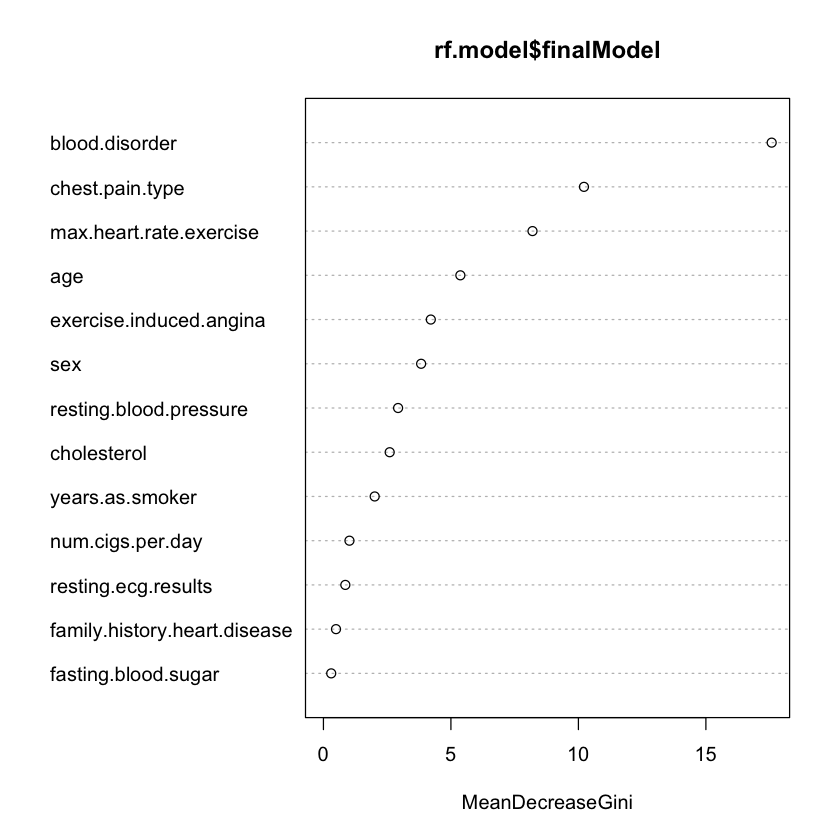

In [14]:
varImp(rf.model)
library(randomForest)
varImpPlot(rf.model$finalModel, scale = F)